In [2]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import copy
print(torch.cuda.is_available())

True


In [3]:
# Create tensors
a = torch.randn(20000, 20000, device="cuda")
b = torch.randn(20000, 20000, device="cuda")

# Perform a matrix multiplication
c = torch.matmul(a, b)
del a, b, c
torch.cuda.empty_cache()

### Generate training tasks
- We want to train a model to predict the outputs of a sin function with different phases and amplitudes, but with only a few examples of each ampltidue and phase

In [4]:
def gen_sinusoid_batch(amp_range=[0.1,5], phase_range=[0, np.pi], x_range=[-5,5],
                       batch_size=32, n_samples=5, dim_input=1, dim_output=1,
                       input_idx=None):
    # sample random phase amd amplitude
    amp = np.random.uniform(amp_range[0], amp_range[1], batch_size)
    phase = np.random.uniform(phase_range[0], phase_range[1], batch_size)
    # generate arrays for input and output samples
    y = np.zeros([batch_size, n_samples, dim_output])
    x_init = np.zeros([batch_size, n_samples, dim_input])
    # each sample in a batch represents a different task
    for func in range(batch_size):
        # n samples is the number of 'shots' for learning
        x_init[func] = np.random.uniform(x_range[0], x_range[1], [n_samples, 1])
        # only used for testing
        if input_idx is not None:
            x_init[:,input_idx:,0] = np.linspace(x_range[0], x_range[1],
                                                 num=n_samples-input_idx, retstep=False)
        y[func] = amp[func] * np.sin(x_init[func]- phase[func])
    return x_init, y, amp, phase

## Now we atually implement MAML itself
#### Inner Loop
- The inner loop updates the model weights for a few specific tasks (in this case sinusoids with specific amplitude and phase)
- This makes the model a bit better at predicting this specific funtion.
#### Outer Loop
- The outer loop evaluates how the slightly updated model performs on the same / related tasks (e.g. sinusoids with different amplitude and phase)
- It computes the meta loss, refelcting the models ability to adapt to the new task.
- The models initial parameters are then updated based on this
- These updated initial parameters should then allow the model to adapt better to similar tasks in future.

In [5]:
# Define the model
class SineModel(nn.Module):
    def __init__(self):
        super(SineModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.net(x)

In [9]:
import argparse
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy


def experiment(run, plot=True, use_cuda=True):
    seed = 0
    inner_step_size = 0.02  # stepsize in inner SGD
    inner_epochs = 1  # number of epochs of each inner SGD
    outer_stepsize_reptile = 0.1  # stepsize of outer optimization, i.e., meta-optimization
    outer_stepsize_maml = 0.01
    n_iterations = 30000  # number of outer updates; each iteration we sample one task and update on it

    rng = np.random.RandomState(seed)
    torch.manual_seed(seed)

    # Define task distribution
    x_all = np.linspace(-5, 5, 50)[:, None]  # All of the x points
    n_train = 10  # Size of training minibatches

    def gen_task():
        "Generate regression problem"
        phase = rng.uniform(low=0, high=2 * np.pi)
        ampl = rng.uniform(0.1, 5)
        f_randomsine = lambda x: np.sin(x + phase) * ampl
        return f_randomsine

    # Define model. Reptile paper uses ReLU, but Tanh gives slightly better results
    model = nn.Sequential(
        nn.Linear(1, 64),
        nn.Tanh(),
        nn.Linear(64, 64),
        nn.Tanh(),
        nn.Linear(64, 1),
    )
    if use_cuda:
        model = model.to('cuda')

    def to_torch(x):
        if use_cuda:
            return ag.Variable(torch.Tensor(x).to('cuda'))
        else:
            return ag.Variable(torch.Tensor(x))

    def train_on_batch(x, y):
        x = to_torch(x)
        y = to_torch(y)
        model.zero_grad()
        ypred = model(x)
        loss = (ypred - y).pow(2).mean()
        loss.backward()
        for param in model.parameters():
            param.data -= inner_step_size * param.grad.data

    def predict(x):
        x = to_torch(x)
        if use_cuda:
            return model(x).cpu().data.numpy()
        else:
            return model(x).data.numpy()

    # Choose a fixed task and minibatch for visualization
    f_plot = gen_task()
    xtrain_plot = x_all[rng.choice(len(x_all), size=n_train)]

    # Training loop
    for iteration in range(n_iterations):
        weights_before = deepcopy(model.state_dict())

        # Generate task
        f = gen_task()
        y_all = f(x_all)

        # Do SGD on this task
        inds = rng.permutation(len(x_all))
        train_ind = inds[:-1 * n_train]
        val_ind = inds[-1 * n_train:]       # Val contains 1/5th of the sine wave

        for _ in range(inner_epochs):
            for start in range(0, len(train_ind), n_train):
                mbinds = train_ind[start:start + n_train]
                train_on_batch(x_all[mbinds], y_all[mbinds])

        if run == 'MAML':
            outer_step_size = outer_stepsize_maml * (1 - iteration / n_iterations)  # linear schedule
            for start in range(0, len(val_ind), n_train):
                dpinds = val_ind[start:start + n_train]
                x = to_torch(x_all[dpinds])
                y = to_torch(y_all[dpinds])

                # Compute the grads
                model.zero_grad()
                y_pred = model(x)
                loss = (y_pred - y).pow(2).mean()
                loss.backward()

                # Reload the model
                model.load_state_dict(weights_before)

                # SGD on the params
                for param in model.parameters():
                    param.data -= outer_step_size * param.grad.data
        else:
            # Interpolate between current weights and trained weights from this task
            # I.e. (weights_before - weights_after) is the meta-gradient
            weights_after = model.state_dict()
            outerstepsize = outer_stepsize_reptile * (1 - iteration / n_iterations)  # linear schedule
            model.load_state_dict({name: weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize
                                   for name in weights_before})

        # Periodically plot the results on a particular task and minibatch
        if plot and iteration == 0 or (iteration + 1) % 1000 == 0:
            plt.cla()
            f = f_plot
            weights_before = deepcopy(model.state_dict())  # save snapshot before evaluation
            plt.plot(x_all, predict(x_all), label="pred after 0", color=(0, 0, 1))
            for inneriter in range(32):
                train_on_batch(xtrain_plot, f(xtrain_plot))
                if (inneriter + 1) % 8 == 0:
                    frac = (inneriter + 1) / 32
                    plt.plot(x_all, predict(x_all), label="pred after %i" % (inneriter + 1), color=(frac, 0, 1 - frac))
            plt.plot(x_all, f(x_all), label="true", color=(0, 1, 0))
            lossval = np.square(predict(x_all) - f(x_all)).mean()
            plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
            plt.ylim(-4, 4)
            plt.legend(loc="lower right")
            plt.pause(0.01)
            model.load_state_dict(weights_before)  # restore from snapshot
            print(f"-----------------------------")
            print(f"iteration               {iteration + 1}")
            print(f"loss on plotted curve   {lossval:.3f}")  # would be better to average loss over a set of examples, but this is optimized for brevity

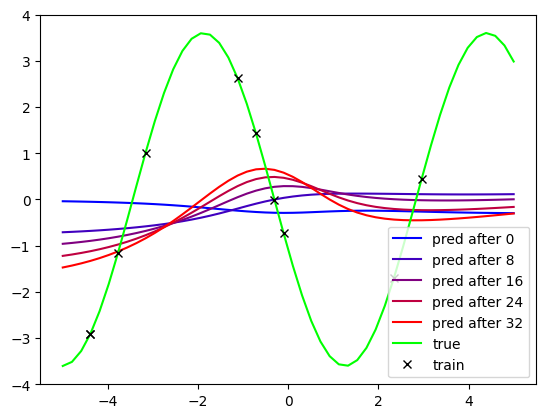

-----------------------------
iteration               1
loss on plotted curve   6.567


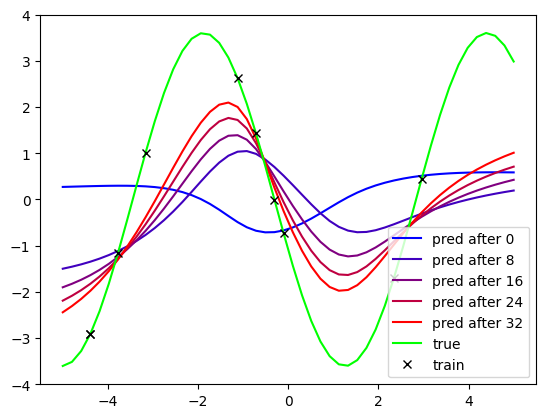

-----------------------------
iteration               1000
loss on plotted curve   2.343


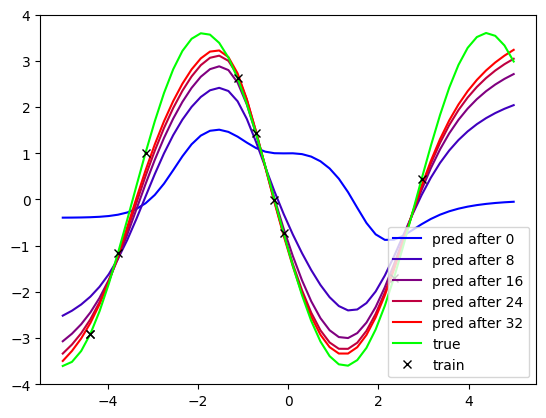

-----------------------------
iteration               2000
loss on plotted curve   0.160


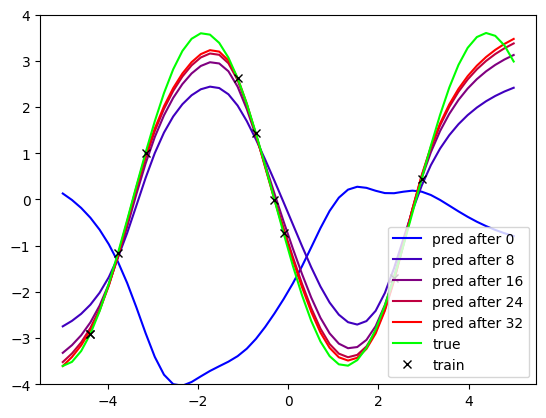

-----------------------------
iteration               3000
loss on plotted curve   0.064


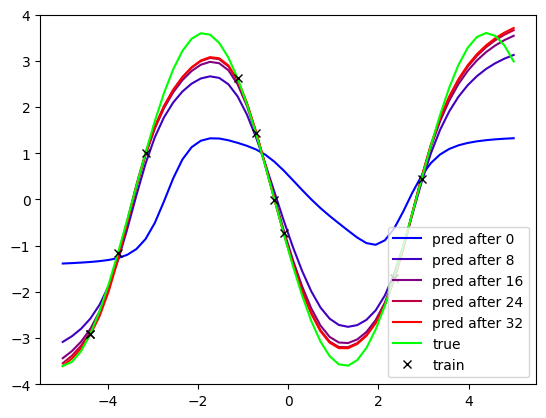

-----------------------------
iteration               4000
loss on plotted curve   0.071


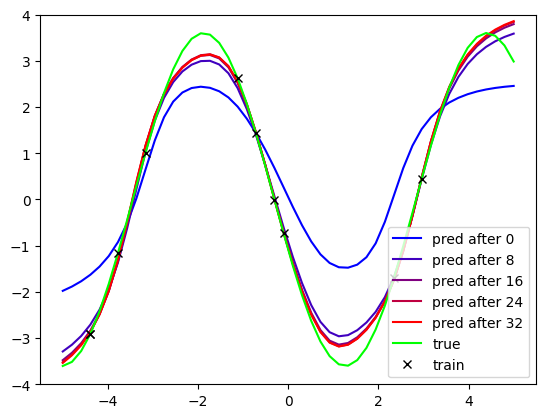

-----------------------------
iteration               5000
loss on plotted curve   0.062


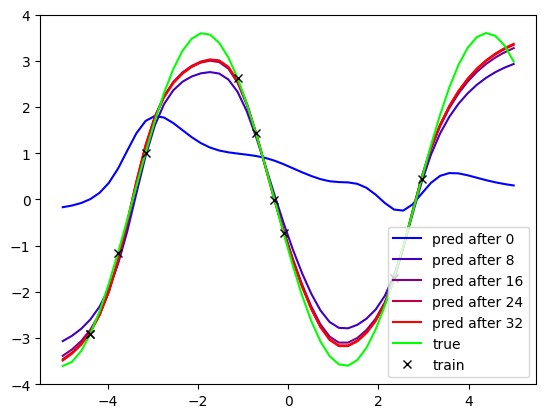

-----------------------------
iteration               6000
loss on plotted curve   0.096


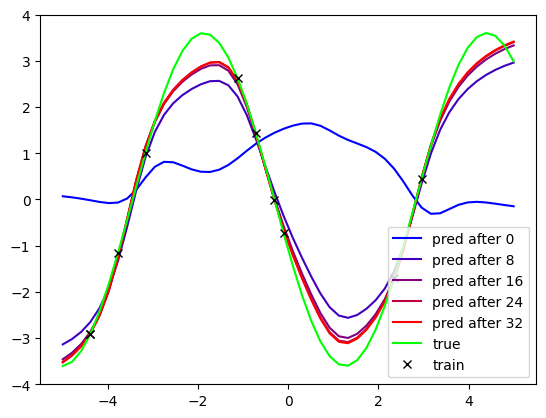

-----------------------------
iteration               7000
loss on plotted curve   0.112


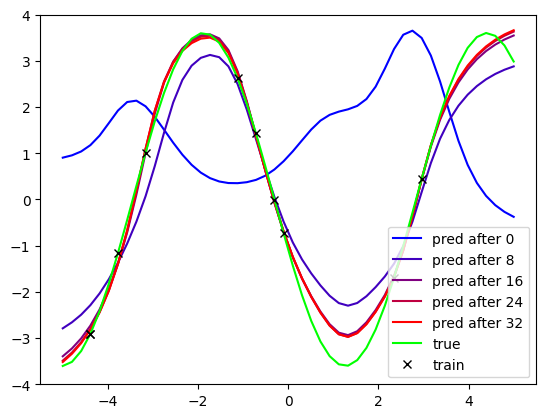

-----------------------------
iteration               8000
loss on plotted curve   0.087


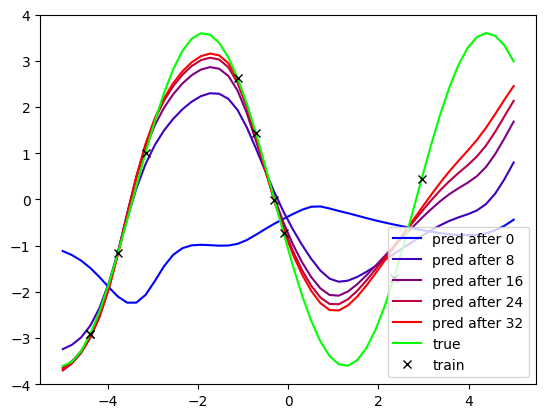

-----------------------------
iteration               9000
loss on plotted curve   0.866


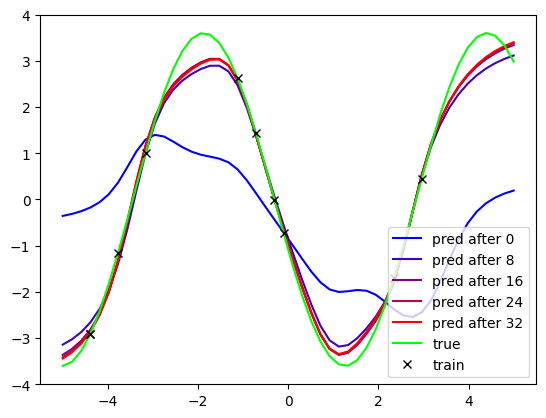

-----------------------------
iteration               10000
loss on plotted curve   0.084


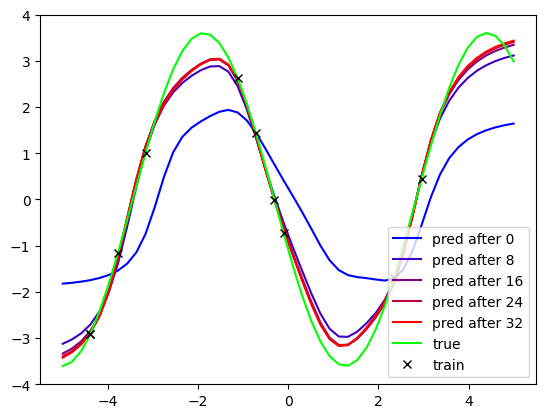

-----------------------------
iteration               11000
loss on plotted curve   0.092


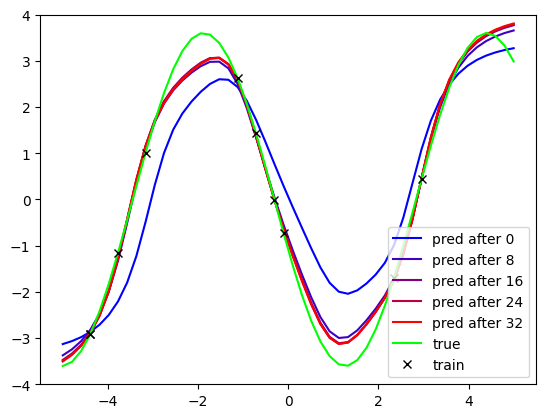

-----------------------------
iteration               12000
loss on plotted curve   0.098


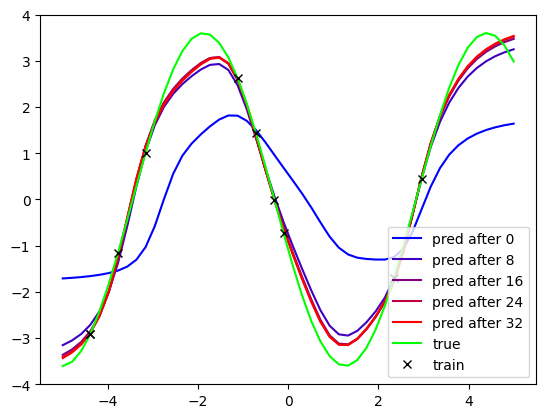

-----------------------------
iteration               13000
loss on plotted curve   0.096


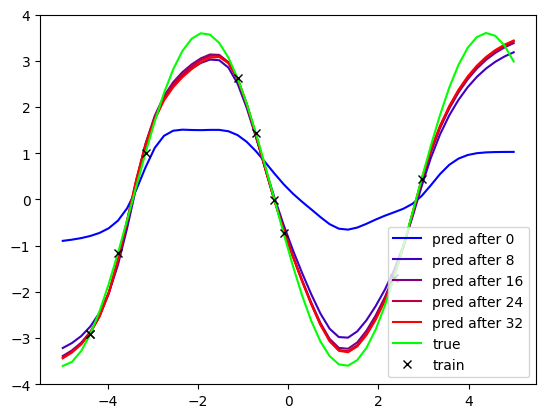

-----------------------------
iteration               14000
loss on plotted curve   0.093


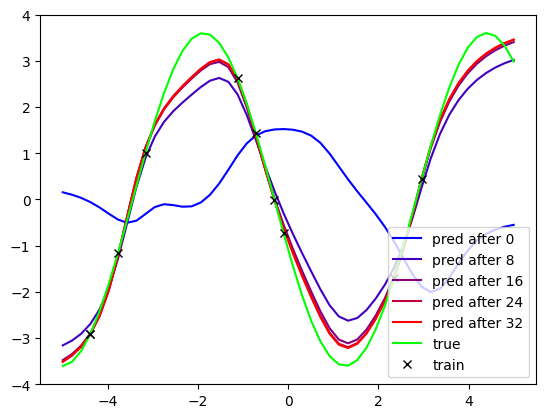

-----------------------------
iteration               15000
loss on plotted curve   0.118


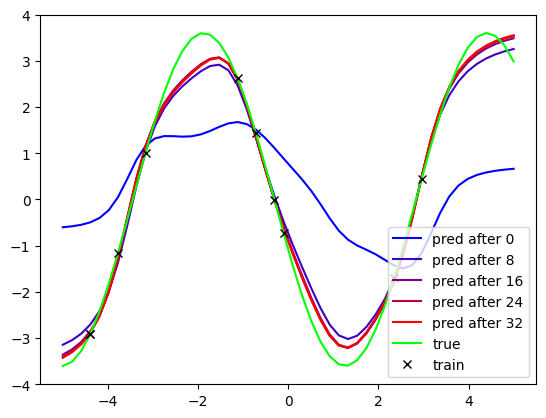

-----------------------------
iteration               16000
loss on plotted curve   0.093


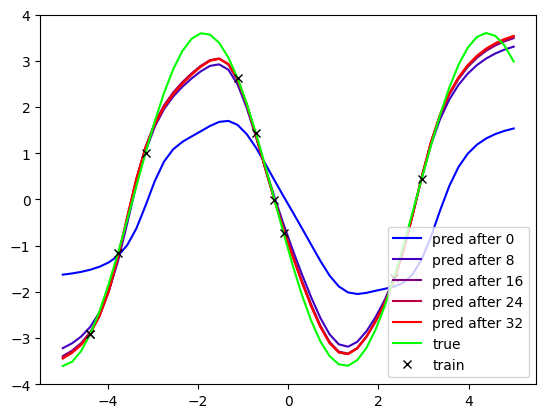

-----------------------------
iteration               17000
loss on plotted curve   0.085


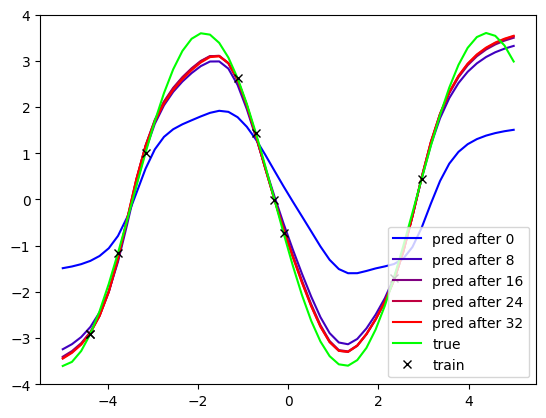

-----------------------------
iteration               18000
loss on plotted curve   0.073


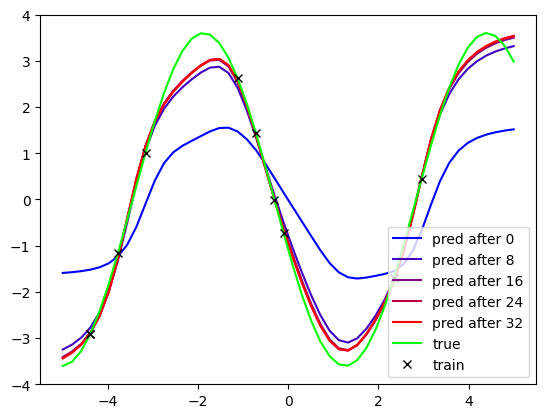

-----------------------------
iteration               19000
loss on plotted curve   0.081


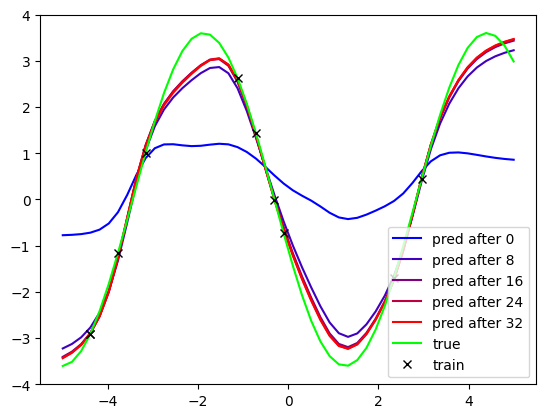

-----------------------------
iteration               20000
loss on plotted curve   0.096


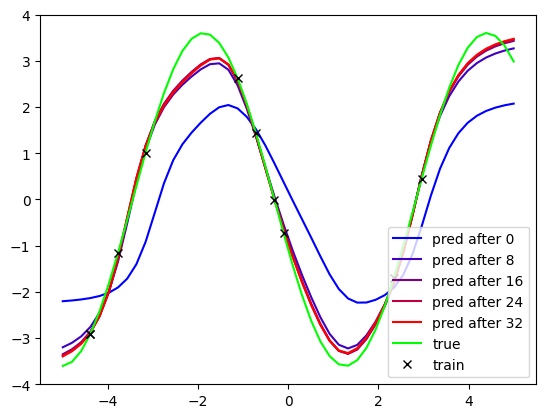

-----------------------------
iteration               21000
loss on plotted curve   0.081


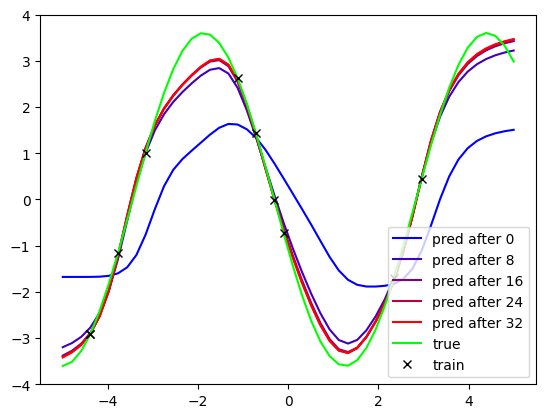

-----------------------------
iteration               22000
loss on plotted curve   0.085


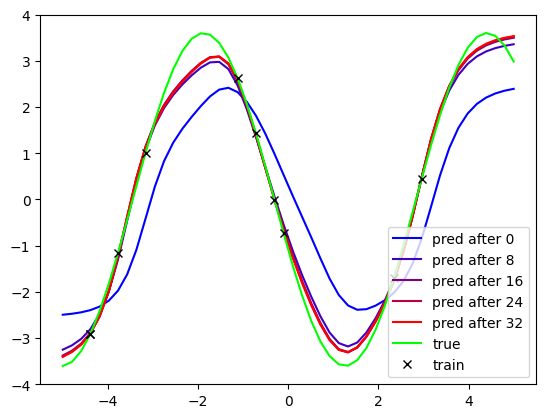

-----------------------------
iteration               23000
loss on plotted curve   0.074


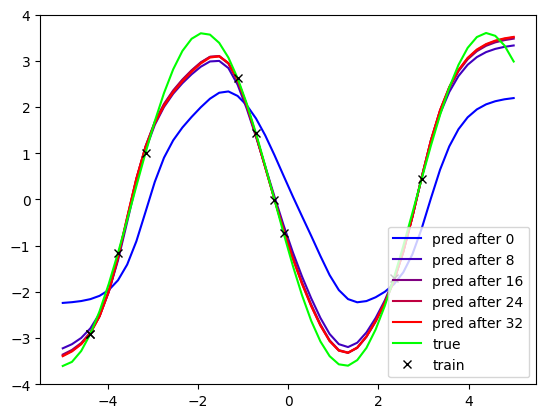

-----------------------------
iteration               24000
loss on plotted curve   0.072


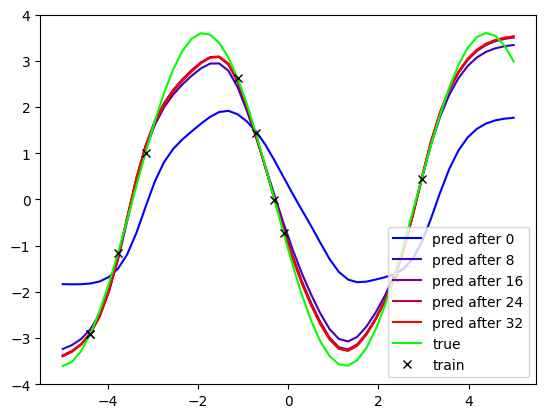

-----------------------------
iteration               25000
loss on plotted curve   0.074


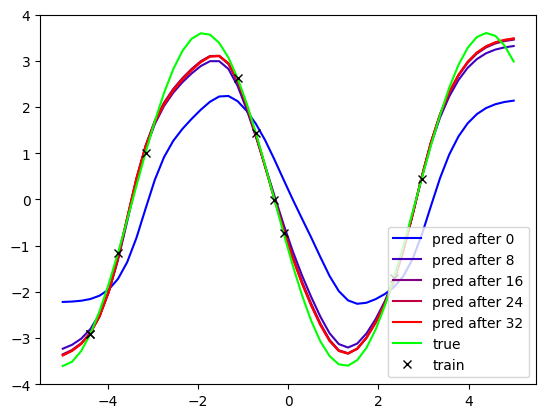

-----------------------------
iteration               26000
loss on plotted curve   0.069


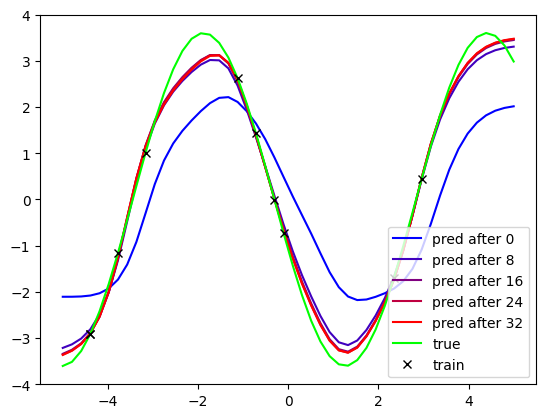

-----------------------------
iteration               27000
loss on plotted curve   0.070


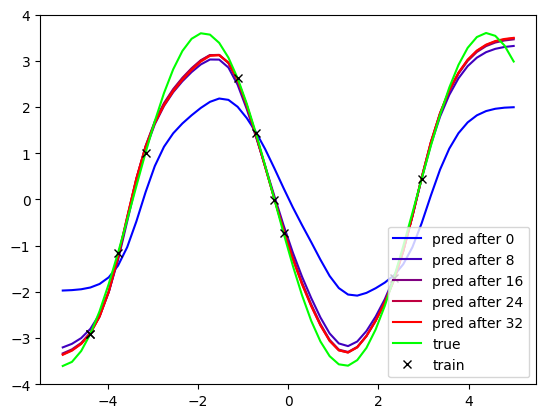

-----------------------------
iteration               28000
loss on plotted curve   0.068


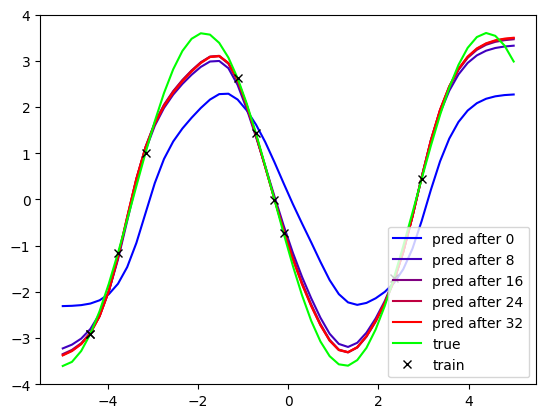

-----------------------------
iteration               29000
loss on plotted curve   0.071


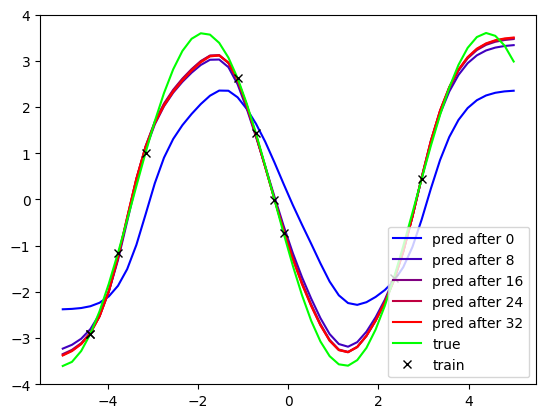

-----------------------------
iteration               30000
loss on plotted curve   0.069


In [10]:
experiment(run='MAML', use_cuda=False)